In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage import feature
from mip import *

Using Python-MIP package version 1.6.7


In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [3]:
def pointwise(n, threshold=0.9):
    m = n.copy()
    shape = m.shape
    m.shape = -1
    for i in range(len(m)):
        m[i] = 0 if m[i] < threshold else np.random.choice([0,1], p=[1-m[i], m[i]])
    m.shape = shape
    return m

In [4]:
def edge(n, sigma=4):
    m = feature.canny(n, sigma=sigma)
    return m

In [5]:
def prob(n, size=1000):
    m = n.copy()
    shape = m.shape
    m.shape = -1
    alpha = size/np.sum(m)
    for i in range(len(m)):
        m[i] = np.random.choice([0,1], p=[1-m[i]*alpha, m[i]*alpha])
    m.shape = shape
    return m

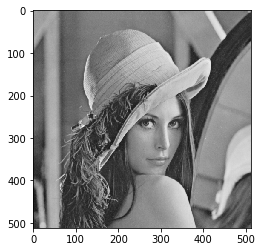

In [6]:
img = mpimg.imread('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png')     
gray = rgb2gray(img)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

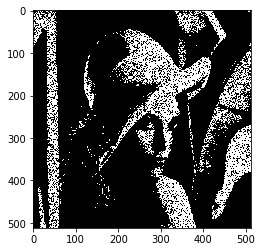

53982.0


In [7]:
pw = pointwise(gray, 0.6)
plt.imshow(pw, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(np.sum(pw))

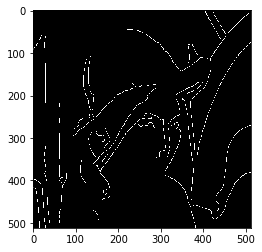

6156


In [8]:
ed1 = edge(gray)
plt.imshow(ed1, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(np.sum(ed1))

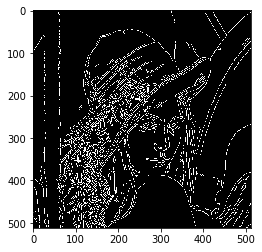

22196


In [9]:
ed2 = edge(gray, 1)
plt.imshow(ed2, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(np.sum(ed2))

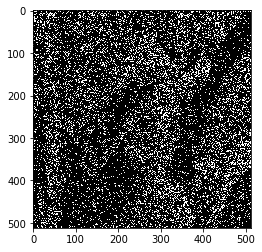

49969.0


In [10]:
pr1 = prob(gray, 50000)
plt.imshow(pr1, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(np.sum(pr1))

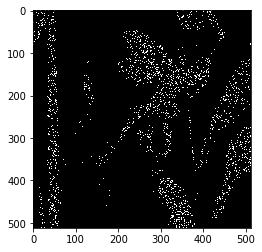

9988.0


In [11]:
pr2 = prob(pw, 10000)
plt.imshow(pr2, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(np.sum(pr2))

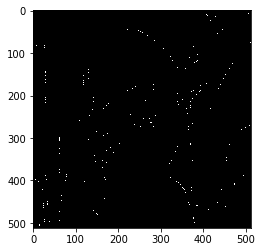

959


In [26]:
pr3 = prob(ed1, 1000)
plt.imshow(pr3, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(np.sum(pr3))

In [31]:
def opt(n, verbose=True):
    coords = [(i,j) for i in range(len(n)) for j in range(len(n)) if n[i,j] == 1]
    n, V = len(coords), set(range(len(coords)))
    dist = lambda a, b: np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    
    c = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            c[i,j] = dist(coords[i], coords[j])
            c[j,i] = c[i,j]    

    m = Model()

    x = [[m.add_var(var_type=BINARY) for j in V] for i in V]
    y = [m.add_var(ub=n-1) for i in V]

    # constraint : leave each city only once
    for i in V:
        m += xsum(x[i][j] for j in V - {i}) == 1

    # constraint : enter each city only once
    for i in V:
        m += xsum(x[j][i] for j in V - {i}) == 1

    # subtour elimination
    for i in V - {0}:
        for j in V - {0}:
            if i != j:
                m += y[i] - y[j] + n*x[i][j] <= n-1
    

    m.objective = minimize(xsum(c[i][j]*x[i][j] for i in V for j in V))

    m.emphasis = 1
#     m.cuts = 3
    m.max_seconds = 1800
    status = m.optimize()
    
    if verbose:
        if status == OptimizationStatus.OPTIMAL:
            print('optimal solution cost {} found'.format(m.objective_value))
        elif status == OptimizationStatus.FEASIBLE:
            print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
        elif status == OptimizationStatus.NO_SOLUTION_FOUND:
            print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
        elif status == OptimizationStatus.INFEASIBLE:
            print('INFEASIBLE'.format(m.objective_bound))
    return m

In [32]:
m = opt(pr3)

no feasible solution found, lower bound is: 8804767122402.555
